In [1]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.version.VERSION)
print(tf.keras.__version__)



1.14.0
2.2.4-tf


In [0]:
import numpy as np
import re
import pandas as pd

In [0]:
def preprocess_text(text):
    text= re.sub(r"^\s+|(@[A-Za-z]+)|([^A-Za-z \t])|(,\w+:\/\/\S+)"," ",text)
    text=" ".join(text.split())
    text= text.lower()
    return text

In [4]:
train = pd.read_table("/content/train.tsv")
print(train.columns)
print(train.shape)
test = pd.read_table("/content/test.tsv")
print(test.columns)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')
(156060, 4)
Index(['PhraseId', 'SentenceId', 'Phrase'], dtype='object')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  after removing the cwd from sys.path.


In [5]:
print(train.dtypes)

PhraseId       int64
SentenceId     int64
Phrase        object
Sentiment      int64
dtype: object


In [0]:
train['Phrase'] = train['Phrase'].apply(lambda x: preprocess_text(x))
test['Sent'] = test['Phrase'].apply(lambda x: preprocess_text(x))

In [0]:
#print(train['Sentiment'].value_counts().plot(kind='bar'))

In [0]:
#print(train.isna().sum())

In [0]:
updated_labels=[]
for i in range(train.shape[0]):
  if train['Sentiment'][i]==0:
    # 1 for negative
    updated_labels.append(1)
  elif train['Sentiment'][i]==4:
    # 3 for positive
    updated_labels.append(3)
  else:
    # 2 for for neutral
    updated_labels.append(train['Sentiment'][i])
train['Sentiment']=updated_labels

AxesSubplot(0.125,0.125;0.775x0.755)


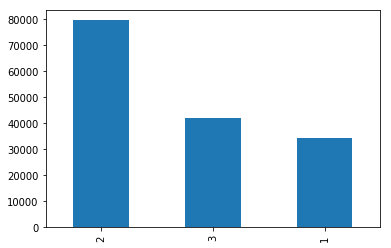

In [10]:
print(train['Sentiment'].value_counts().plot(kind='bar'))

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop]
    return ' '.join(no_stopword_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
train['Phrase'] = train['Phrase'].apply(lambda x: remove_stopwords(x))
test['Sent'] =  test['Sent'].apply(lambda x: remove_stopwords(x))

In [0]:
for i in range(len(train['Phrase'])):
  if train['Phrase'][i]=='':
    train.drop([i],axis=0,inplace=True)
train.reset_index(inplace=True)
for i in range(len(test['Phrase'])):
  if test['Sent'][i]=='':
    test.drop([i],axis=0,inplace=True)
test.reset_index(inplace=True)
    

In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    split=text.split(' ')
    lem_sen=' '.join([lemmatizer.lemmatize(w,'v') for w in split])
    return lem_sen

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
train['Phrase']= train['Phrase'].apply(lambda x: lemmatize(x))
test['Sent']= test['Sent'].apply(lambda x: lemmatize(x))

In [16]:
from keras.preprocessing.text import Tokenizer
token=Tokenizer()
token.fit_on_texts(train['Phrase'].values)

Using TensorFlow backend.


In [0]:
train['vectors']=token.texts_to_sequences(train['Phrase'])
test['vectors']=token.texts_to_sequences(test['Sent'])
#print(train['vectors'][0:5])

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
len_train = max([len(s.split()) for s in train['Phrase']])
len_test = max([len(s.split()) for s in test['Sent']])
if len_train>len_test:
  max_length = len_train
else:
  max_length = len_test
train_vectors = pad_sequences(train['vectors'], max_length)
test_vectors = pad_sequences(test['vectors'], max_length)
#print(train_vectors.shape)


In [19]:
from keras.utils import to_categorical
target=train.Sentiment.values
labels=to_categorical(target-1)
num_classes=labels.shape[1]
print(labels)
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val= train_test_split(train_vectors,labels,test_size=0.2,random_state=4)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding,GlobalAveragePooling1D


In [21]:
EMBEDDING_DIM = 100
unknown = len(token.word_index)+1
model = Sequential()
model.add(Embedding(unknown, EMBEDDING_DIM, input_length = max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(50, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))
model.summary()

W0824 16:30:14.563971 139632272365440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0824 16:30:14.590100 139632272365440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1239800   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,245,003
Trainable params: 1,245,003
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [23]:
history = model.fit(x_train,
                    y_train,
                    epochs = 5,
                    batch_size = 512,
                    validation_data = (x_val,y_val),
                    verbose = 1)


Train on 123700 samples, validate on 30925 samples


W0824 16:30:14.996410 139632272365440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
123700/123700 [==============================] - 6s 45us/sample - loss: 0.5657 - acc: 0.7153 - val_loss: 0.4905 - val_acc: 0.7692
Epoch 2/5
123700/123700 [==============================] - 5s 42us/sample - loss: 0.4367 - acc: 0.8014 - val_loss: 0.4221 - val_acc: 0.8109
Epoch 3/5
123700/123700 [==============================] - 5s 43us/sample - loss: 0.3875 - acc: 0.8306 - val_loss: 0.4082 - val_acc: 0.8221
Epoch 4/5
123700/123700 [==============================] - 5s 43us/sample - loss: 0.3658 - acc: 0.8416 - val_loss: 0.4025 - val_acc: 0.8250
Epoch 5/5
123700/123700 [==============================] - 5s 43us/sample - loss: 0.3537 - acc: 0.8482 - val_loss: 0.4053 - val_acc: 0.8260


In [24]:
results = model.evaluate(x_train,y_train)
print("Training Accuracy",results[1])


123700/123700 [==============================] - 4s 30us/sample - loss: 0.3360 - acc: 0.8564
Training Accuracy 0.8563586


In [0]:
predict = model.predict_classes(test_vectors)


In [0]:
import csv
output = pd.DataFrame(columns=['Phrases','Sentiment'])
sent=[]
label=[]
for i in range(test.shape[0]):
  sent.append(test['Phrase'][i])
  label.append(predict[i]+1)
output['Phrases'] = sent
output['Label'] = label
#output.to_csv("/content/ann_sa.csv")
